In [2]:
import re

import pandas as pd
from pathlib import Path
from ploting import *

In [3]:
root_path = "horeka"

In [4]:
name_re = re.compile("(weak|strong)_scaling-d_(\d+)-n_(\d+)-(no_)?graph_comm-(gpu|cpu)-nodes_(\d+)")

In [5]:
time_re = re.compile("DURATION:\s*(\d+(\.\d+)?(e[+-]\d+)?)")

In [6]:
def create_df(path):
    data = []
    for file in Path(f"{path}/data").iterdir():
        if m := name_re.search(file.name):
            with open(file, "r") as input:
                if t_m := time_re.search(input.read()):
                    duration = t_m.group(1)
                    data.append({"scaling": m.group(1), "dim": m.group(2), "n": m.group(3), "graph_comm": bool(m.group(4)),
                                 "type": m.group(5), "nodes": m.group(6), "time": duration})
    return pd.DataFrame(data).drop(columns=["scaling", "type", "graph_comm"]).astype({"dim": int, "n": int, "nodes": int, "time": float})

In [7]:
def pivot(df):
    piv = df.pivot(index="nodes", columns=["dim", "n"], values="time")
    return piv[piv.columns.sort_values()]

In [8]:
df_gpu_aware = create_df("horeka")
df_gpu_aware = pivot(df_gpu_aware)
df_gpu_aware

dim           2                                                 3            \
n       100       1000      10000     100000    1000000   100       1000      
nodes                                                                         
1      0.000040  0.000041  0.000045  0.000064  0.000270  0.000035  0.000041   
2      0.000043  0.000044  0.000044  0.000059  0.000292  0.000046  0.000058   
4      0.000038  0.000039  0.000042  0.000206  0.001198  0.000054  0.000064   
7      0.000038  0.000040  0.000041  0.000055  0.001130  0.000055  0.000200   
14     0.000039  0.000040  0.000043  0.000056  0.000257  0.000062  0.000075   
28     0.000041  0.000042  0.000047  0.000060  0.000255  0.000070  0.000073   
56     0.000045  0.000045  0.000049  0.000391  0.001163  0.000074  0.000076   

dim                                  
n       10000     100000    1000000  
nodes                                
1      0.000064  0.000164  0.000525  
2      0.000080  0.000148  0.000723  
4      0.000870  0.000352  0.000726  
7      0.000095  0.000355  0.000710  
14     0.000093  0.000501  0.000630  
28     0.000682  0.000434  0.000574  
56     0.000094  0.000431  0.000575

In [9]:
df_gpu_unaware = create_df("horeka-no-gpu-aware-mpi")
df_gpu_unaware = pivot(df_gpu_unaware)
df_gpu_unaware

dim           2                                                 3            \
n       100       1000      10000     100000    1000000   100       1000      
nodes                                                                         
1      0.000089  0.000091  0.000094  0.000113  0.000335  0.000092  0.000097   
2      0.000090  0.000092  0.000096  0.000116  0.000336  0.000096  0.000101   
4      0.000093  0.000095  0.000100  0.000123  0.000345  0.000099  0.000103   
7      0.000094  0.000097  0.000101  0.000124  0.000325  0.000099  0.000105   
14     0.000096  0.000097  0.000102  0.000130  0.000347  0.000107  0.000113   
28     0.000099  0.000099  0.000105  0.000134  0.000324  0.000117  0.000123   
56     0.000102  0.000103  0.000107  0.000118  0.000326  0.000122  0.000129   

dim                                  
n       10000     100000    1000000  
nodes                                
1      0.000112  0.000240  0.000944  
2      0.000121  0.000273  0.001081  
4      0.000128  0.000274  0.001107  
7      0.000128  0.000282  0.001072  
14     0.000135  0.000295  0.001631  
28     0.000151  0.000330  0.001637  
56     0.000157  0.000349  0.001643

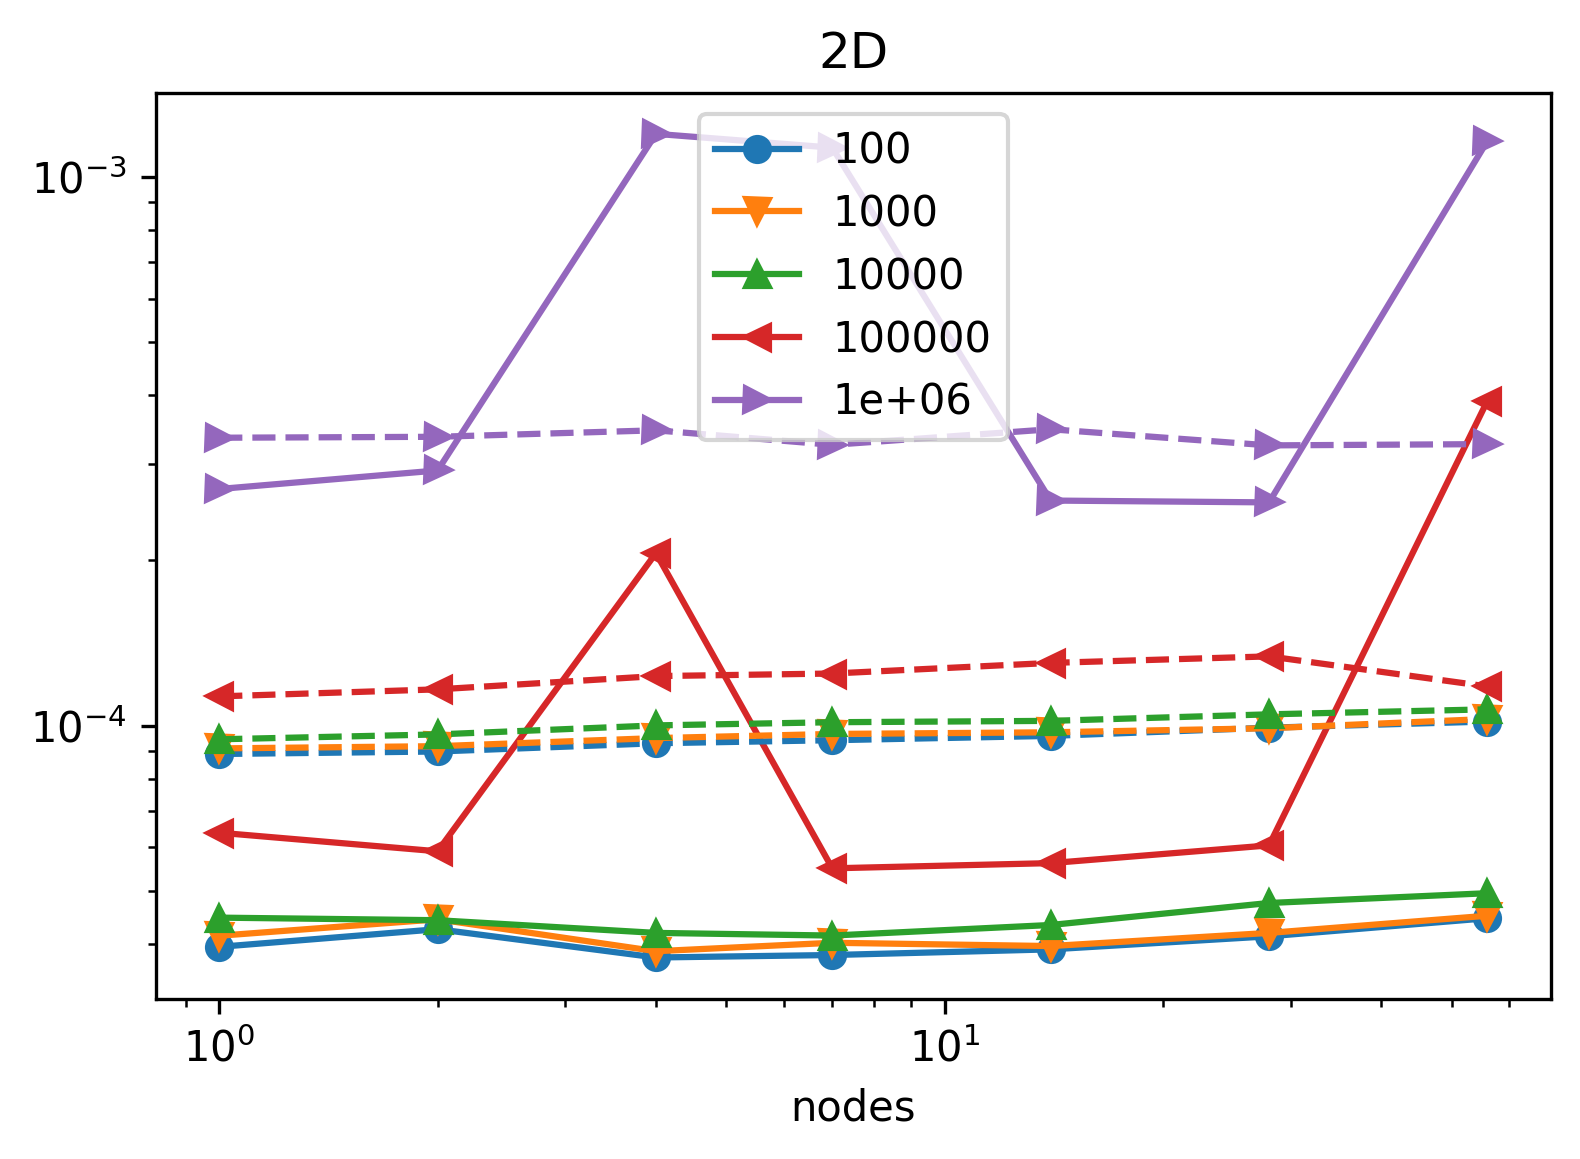

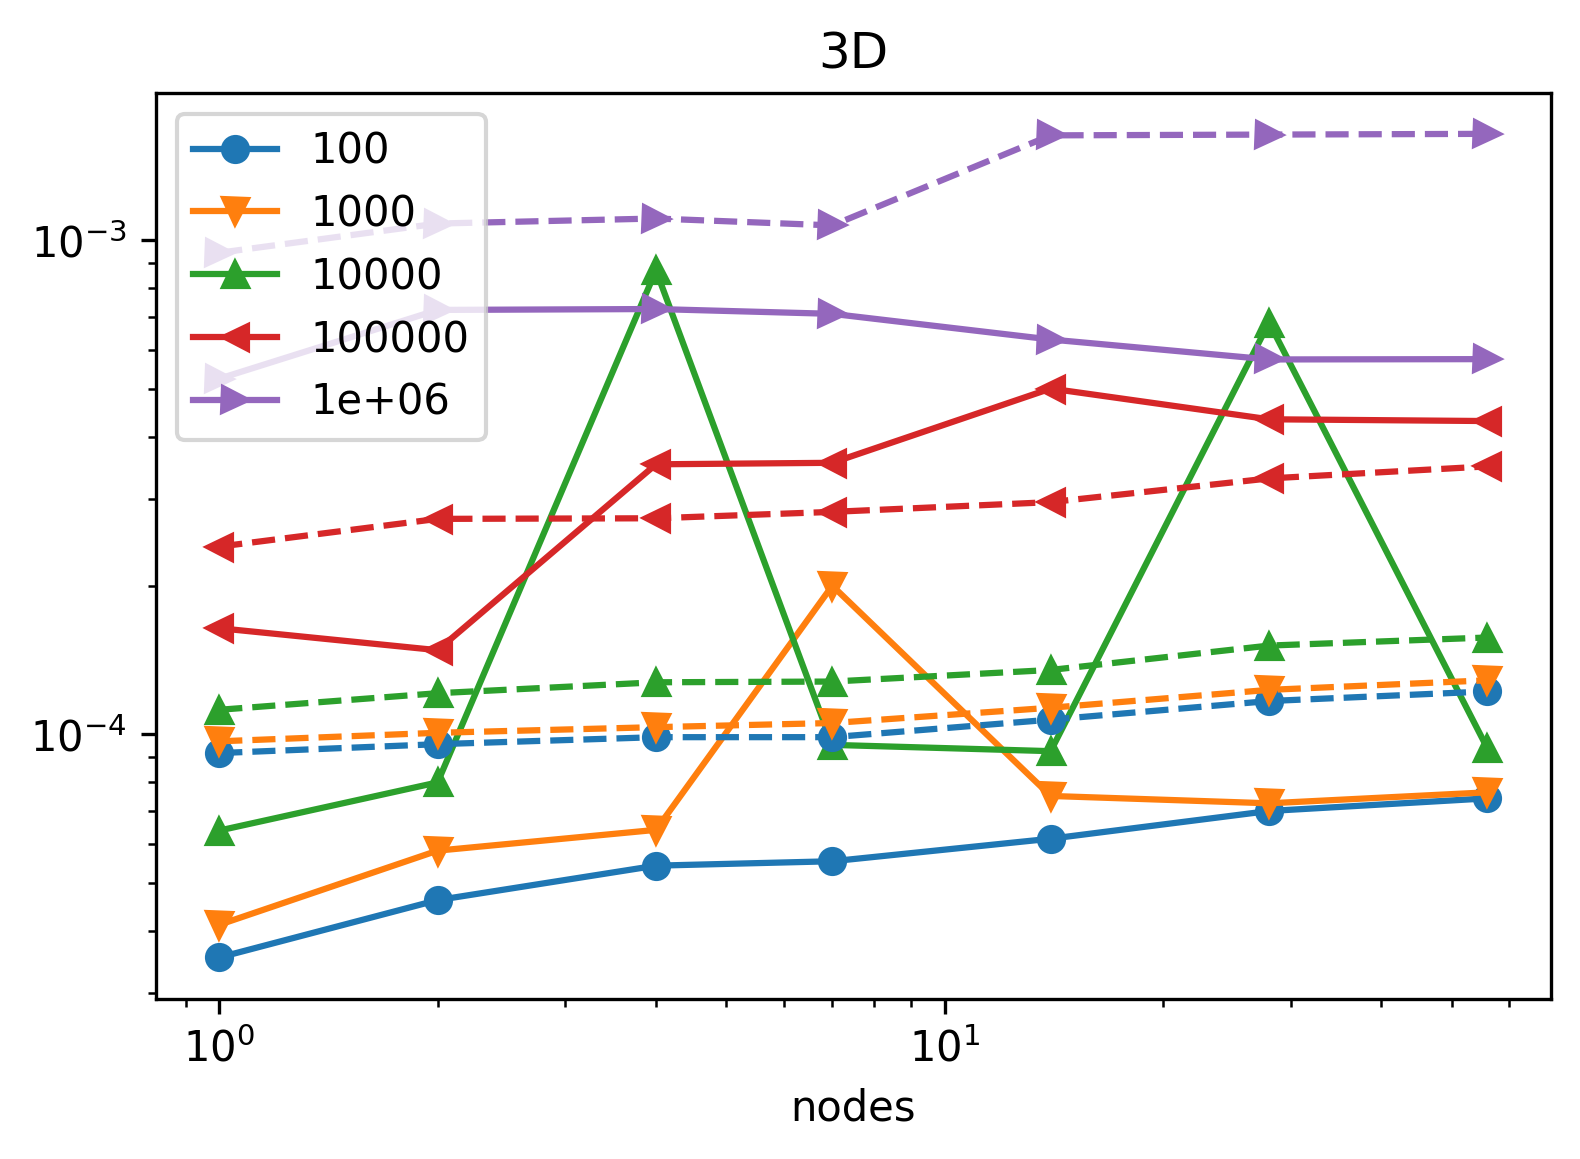

In [10]:
for dim in df_gpu_unaware.columns.levels[0]:
    fig, ax = plt.subplots(dpi=300)
    for piv, is_gpu_aware in [(df_gpu_aware, True), (df_gpu_unaware, False)]:
        _df = piv[dim]
        ax.set_prop_cycle(default_cycler if is_gpu_aware else dashed_cylcer)
        ax.set_title(f"{dim}D")
        _df.plot(ax=ax, legend=False, logx=True, logy=True)
        if is_gpu_aware:
            ax.legend([f"{n:g}" for n in piv.columns.levels[1]])
    fig.savefig(f"runtime-mpi-comparison-{dim}d.png")